#### In this notebook, a simple feed forward network is trained using graph neural networks to predict energies.

#### Import some required libraries

In [2]:

## Standard libraries
import numpy as np
import pandas as pd
import os
import pickle

## For some analysis
import MDAnalysis as mda
from MDAnalysis.analysis import distances

## For plotting
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec

## For visualization
import nglview as nv

## For some data pre-processing
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA, KernelPCA

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

## For neural network training
import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

from torch.utils.tensorboard import SummaryWriter

#### Global matplot font settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

#### Read positions and properties

In [4]:

#### Sorted universe 

print('Creating a MD analysis universe from the given structure') 
sorted_isomers_universe = mda.Universe("data/isomers_formatted.xyz")

print('Universe created.')

print(f'Number of structures in the given file: {sorted_isomers_universe.trajectory.n_frames}')
      

Creating a MD analysis universe from the given structure
Universe created.
Number of structures in the given file: 6095


In [5]:

pbe_energies = pd.read_csv('data/energies.txt', 
                           comment="#", 
                           names=['structure', 'energy'], 
                           delim_whitespace=True)

    
# Scale output energies to the range -1 to 1.
y_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_scaler.fit(pbe_energies.energy.values.reshape(-1,1))
y_scaled = y_scaler.transform(pbe_energies.energy.values.reshape(-1,1))
y_scaled = np.array(y_scaled)


/var/folders/34/mgxv50fj6kg2stdwcd8bnwn80000gn/T/ipykernel_26013/1884438073.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pbe_energies = pd.read_csv('data/energies.txt',


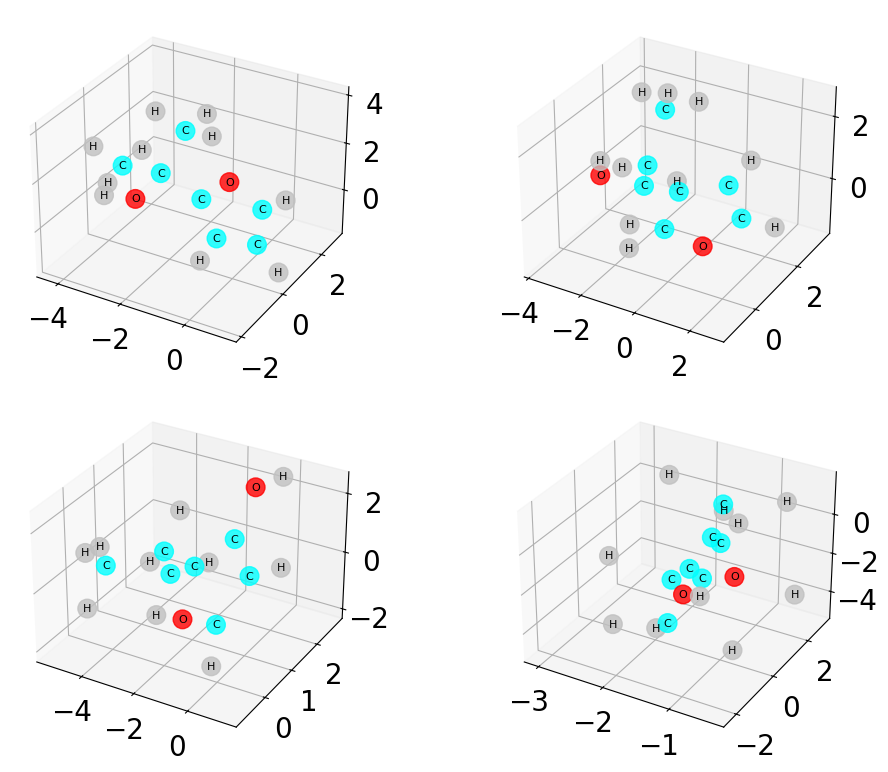

In [6]:
# SOURCE,CREDITS: https://projects.volkamerlab.org/teachopencadd/talktorials/T036_e3_equivariant_gnn.html

import matplotlib.colors as mcolors

def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """
    Auxiliary function, useful for choosing label colors
    with good visibility
    """
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1


def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    color: np.ndarray,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    annotations: list = None,
    annotate_points: bool = True,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
    cbar: bool = False
) -> mpl.axis.Axis:
    """Visualize colored 3D point clouds.

    Parameters
    ----------
    fig : mpl.figure.Figure
        The figure for which a new axis object is added for plotting
    ax_pos : int
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`)
    color : np.ndarray
        The point colors as a float array of shape `(N,)`
    pos : np.ndarray
        The point xyz-coordinates as an array
    cmap : str, optional
        String identifier for a matplotlib colormap.
        Is used to map the values in `color` to rgb colors.
        , by default "plasma"
    point_size : float, optional
        The size of plotted points, by default 180.0
    label_axes : bool, optional
        whether to label x,y and z axes by default False
    annotations: list, optional
        annotations for annotating each node.
    annotate_points : bool, optional
        whether to label points with their index, by default True
    cbar_label : str, optional
        label for the colorbar, by default ""

    Returns
    -------
    mpl.axis.Axis
        The new axis object for the 3D point cloud plot.
    """
    cmap = mpl.colormaps.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    
    if cbar:
        sc = ax.scatter(x, y, z, c=color, cmap=cmap, s=point_size)
        plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
                
    else:
        sc = ax.scatter(x, y, z, color=color, alpha=0.8, s=point_size)
        
    if annotate_points:
        for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
            ax.text(xi, yi, zi, annotations[i], None, color='black', fontsize=8, ha="center", va="center")
        
    return ax


# testing
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.01, hspace=0.01)

ax_pos = [221, 222, 223, 224]

# define color based on atom names
atom_names = sorted_isomers_universe.select_atoms('all').atoms.names
colors = {'C': 'cyan', 'O': 'red', 'H': 'silver'}
atom_colors = []
for i in range(atom_names.shape[0]):
    atom_colors.append(colors[atom_names[i]])

# Visualize first four structures 
for i, ts in enumerate(sorted_isomers_universe.trajectory[:4]):
    
    pos = sorted_isomers_universe.select_atoms('all').positions.T
    
    #color = ['blue']#np.random.rand(pos.shape[1])
    color = atom_colors
    
    plot_point_cloud_3d(fig, ax_pos[i], color, pos, annotations=atom_names, 
                        annotate_points=True, remove_axes_ticks=False)

#fig.suptitle("Random test point clouds")
plt.tight_layout()



#### Construct the adjacency matrix with atoms as nodes and edges as pairwise distances

In [8]:

class DistanceGraph(nn.Module):
    
    def __init__(self, num_atoms, distance_cutoff):
        
        super(DistanceGraph, self).__init__()
        self.num_atoms = num_atoms
        self.num_edges = num_atoms * (num_atoms - 1) // 2
        self.distance_cutoff = distance_cutoff
        
        
    def create_edge_index(self):
        
        edge_index = []
        for i in range(self.num_atoms):
            for j in range(i+1, self.num_atoms):
                edge_index.append([i, j])
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        return edge_index
    
    def create_edge_index(self):
        edge_index = []
        edge_distances = []
        for i in range(self.num_atoms):
            for j in range(i+1, self.num_atoms):
                distance = torch.norm(self.positions[i] - self.positions[j]) #ASSUME PBC NOT REQUIRED
                #print(distance)
                if distance <= self.distance_cutoff:
                    edge_index.append([i, j])
                    edge_distances.append(distance)
                    
        #print(edge_index)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_distances = torch.tensor(edge_distances, dtype=torch.float)
        return edge_index, edge_distances
    
    
    def forward(self, x, positions, time, y):
        
        self.x = x
        self.positions = positions
        self.time = time
        self.y=y
        
        self.edge_index, self.edge_dists = self.create_edge_index()
                
        edge_attr = self.edge_dists # torch.ones(self.edge_index.size(1), dtype=torch.float) 
                
        data = Data(x=self.x, edge_index=self.edge_index, edge_attr=np.round(edge_attr,2), 
                    time=self.time, y=self.y)
        
        return data

    

array([12.011, 12.011, 12.011, 12.011, 12.011, 12.011, 12.011,  1.008,
        1.008,  1.008,  1.008,  1.008,  1.008,  1.008,  1.008,  1.008,
        1.008, 15.999, 15.999])

In [ ]:
distance_graph = DistanceGraph(sorted_isomers_universe.atoms.n_atoms, 1.7)
selection = sorted_isomers_universe.select_atoms('all')
node_features = torch.Tensor(sorted_isomers_universe.atoms.masses) #torch.ones(selection.atoms.n_atoms).reshape(-1,1)


graph_data_time = []
for i, ts in enumerate(sorted_isomers_universe.trajectory):
    
    positions_tensor = torch.tensor(selection.positions, dtype=torch.float)
    graph_data = distance_graph(node_features, positions_tensor, time=ts.time, y=torch.tensor(y_scaled[i], dtype=torch.float32))

    graph_data_time.append(graph_data)
    

/var/folders/34/mgxv50fj6kg2stdwcd8bnwn80000gn/T/ipykernel_26013/1496541852.py:10: UserWarning: Reader has no dt information, set to 1.0 ps
  graph_data = distance_graph(node_features, positions_tensor, time=ts.time, y=torch.tensor(y_scaled[i], dtype=torch.float32))


In [10]:
graph_data_time[6000], pbe_energies.energy.values[6000], y_scaled[6000]

(Data(x=[19, 1], edge_index=[2, 19], edge_attr=[19], y=[1], time=6000.0),
 -11506.617642999,
 array([-0.6899584]))

In [11]:
sorted_isomers_universe.atoms.masses 

array([12.011, 12.011, 12.011, 12.011, 12.011, 12.011, 12.011,  1.008,
        1.008,  1.008,  1.008,  1.008,  1.008,  1.008,  1.008,  1.008,
        1.008, 15.999, 15.999])

#### plot an example molecule

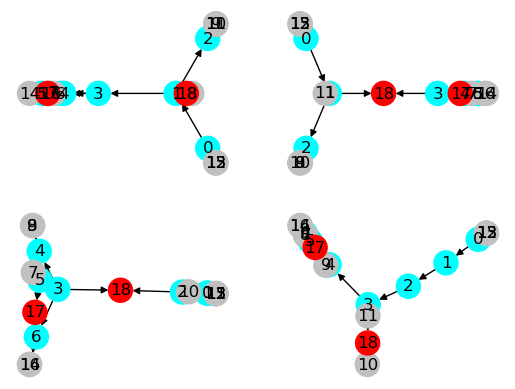

In [12]:
# Create a 2x2 subplot
fig, all_axes = plt.subplots(2, 2)
ax = all_axes.flat

for i,select_graph in enumerate([1, 10, 100, 1000]):

    edge_attr = graph_data_time[select_graph].edge_attr
    nx_graph = to_networkx(graph_data_time[select_graph], edge_attrs=["edge_attr"])
    pos = nx.spectral_layout(nx_graph, weight='weight')
    #pos = nx.spring_layout(nx_graph)
    
    edge_labels = nx.get_edge_attributes(nx_graph, 'edge_attr')
    edge_labels = dict([((u,v,), f"{d['edge_attr']:.2f}") for u,v,d in nx_graph.edges(data=True)])
    nx.draw(nx_graph, with_labels=True, node_color=atom_colors, ax=ax[i], pos=pos)
    # nx.draw_networkx_edge_labels(nx_graph, pos=pos, edge_labels = edge_labels, 
    #                              font_size=8, verticalalignment='bottom')


#### Graph convolutional network

In [185]:

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
writer = SummaryWriter('./tensorflow_logs')

#torch.manual_seed(1234567)    
# Simple GNN model
class GCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.lin = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, edge_index, batch):
        
        #x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.lin(x)
        
        return x
    
    
def training(loader, model, loss, optimizer):
    
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        
        optimizer.zero_grad()
        
        d.x = d.x.float()
        
        out = model(d.x, d.edge_index, d.batch)
        
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        
        current_loss += l / len(loader)
        
        l.backward()
        
        optimizer.step()
        
    return current_loss, model


def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    val_target = np.empty((0))
    val_y_target = np.empty((0))
    for d in loader:
        out = model(d.x, d.edge_index, d.batch)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)

        val_target = np.concatenate((val_target, out.detach().numpy()[:,0]))
        val_y_target = np.concatenate((val_y_target, d.y.detach().numpy()))
    
    return val_loss, val_target, val_y_target
    

def train_epochs(epochs, model, train_loader, val_loader, path, lr, criterion):
    
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #, weight_decay=5e-4)
    loss = criterion

    train_target = np.empty((0))
    train_y_target = np.empty((0))
    train_loss = np.empty(epochs)
    val_loss = np.empty(epochs)
    val_target = np.empty((0))
    val_y_target = np.empty((0))
    # best_loss = math.inf

    for epoch in range(epochs):

        epoch_loss, model = training(train_loader, model, loss, optimizer)

        v_loss, v_target, v_y_target = validation(val_loader, model, loss)
        
        if epoch == epochs - 1:
            val_target = np.concatenate((val_target, v_target))
            val_y_target = np.concatenate((val_y_target, v_y_target))
        
#         if v_loss < best_loss:
#             torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d.x, d.edge_index, d.batch)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = np.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = np.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        writer.add_scalar('Loss/train',  train_loss[epoch], epoch)
        writer.add_scalar('Loss/validation',  val_loss[epoch], epoch)
        weight_histograms(writer, epoch, model)
        

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
            
    return train_target, train_y_target, train_loss , val_target, val_y_target, val_loss


#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md
def weight_histograms_gcc(writer, step, weights, layer_number):
  weights_shape = weights.shape
  num_kernels = weights_shape[0]
  for k in range(num_kernels):
    flattened_weights = weights[k].flatten()
    tag = f"layer_{layer_number}/kernel_{k}"
    writer.add_histogram(tag, flattened_weights, global_step=step, bins='tensorflow')


def weight_histograms_linear(writer, step, weights, layer_number):
  flattened_weights = weights.flatten()
  tag = f"layer_{layer_number}"
  writer.add_histogram(tag, flattened_weights, global_step=step, bins='tensorflow')


def weight_histograms(writer, step, model):
  #print("Visualizing model weights...")
  # Iterate over all model layers
  #for layer_number in range(len(model.layers)):
  for l, layer in enumerate(model.children()):
    # Get layer
    # Compute weight histograms for appropriate layer
    if isinstance(layer, GCNConv):
      weights = layer.get_parameter('lin.weight')
      weight_histograms_gcc(writer, step, weights, l)
    elif isinstance(layer, nn.Linear):
      weights = layer.get_parameter('weight')
      weight_histograms_linear(writer, step, weights, l)

        

#### Training, testing and validation data

In [186]:

from torch_geometric.loader import DataLoader


# data split
data_size = sorted_isomers_universe.trajectory.n_frames
train_index = int(data_size * 0.95)
test_index = train_index + int(data_size * 0.025)
val_index = test_index + int(data_size * 0.025)

batch_size=1000

# datasets into DataLoader
train_loader = DataLoader(graph_data_time[0:train_index], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graph_data_time[train_index:test_index], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(graph_data_time[test_index:val_index], batch_size=batch_size, shuffle=True)


#### Train the model

In [202]:
# training GCN for 10 epochs
epochs = 1000
model = GCN(input_dim=1, hidden_dim=12, output_dim=1)

train_values = train_epochs(epochs, model, train_loader, val_loader, "GCN_model.pt", lr=0.005, criterion=nn.MSELoss())

gcn_train_target, gcn_train_y_target, gcn_train_loss, gcn_val_target, gcn_val_y_target, gcn_val_loss = train_values


# Create an instance of the TensorObject class with a variable x
dataiter = iter(train_loader)
data = next(dataiter)

writer.add_graph(model,  [data.x, data.edge_index, data.batch])

writer.flush()
writer.close()

Epoch: 0, Train loss: 0.08024647831916809, Val loss: 0.1649763435125351
Epoch: 2, Train loss: 0.07979356497526169, Val loss: 0.14319010078907013
Epoch: 4, Train loss: 0.07930030673742294, Val loss: 0.1512800008058548
Epoch: 6, Train loss: 0.07937975227832794, Val loss: 0.14762036502361298
Epoch: 8, Train loss: 0.07928965985774994, Val loss: 0.14867345988750458
Epoch: 10, Train loss: 0.0793561041355133, Val loss: 0.1490129977464676
Epoch: 12, Train loss: 0.07924428582191467, Val loss: 0.14856338500976562
Epoch: 14, Train loss: 0.07942378520965576, Val loss: 0.14898918569087982
Epoch: 16, Train loss: 0.07903200387954712, Val loss: 0.14792849123477936
Epoch: 18, Train loss: 0.0791671872138977, Val loss: 0.1489013284444809
Epoch: 20, Train loss: 0.07907812297344208, Val loss: 0.1470530480146408


KeyboardInterrupt: 

In [ ]:
data.x

#### Check training performance

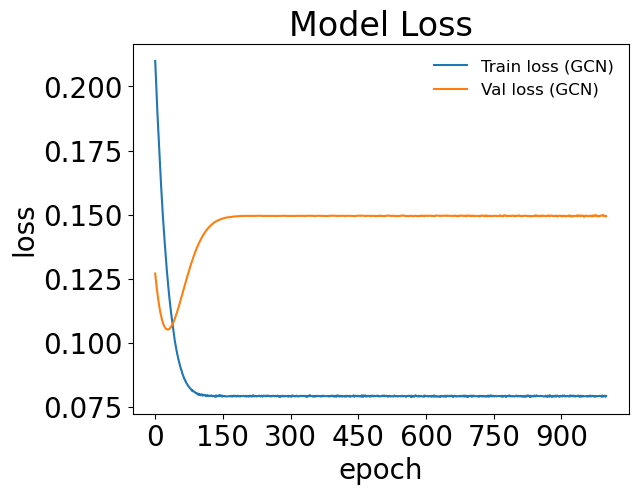

In [192]:
plt.plot(gcn_train_loss, label="Train loss (GCN)")
plt.plot(gcn_val_loss, label="Val loss (GCN)")


plt.legend(frameon=False, fontsize=12)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Model Loss")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


#### Check correlation of true values agains predictions

In [196]:
#### Obtain test values

@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = np.empty((0))
    test_y_target = np.empty((0))
    for d in loader:
        out = model(d.x, d.edge_index, d.batch)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = np.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = np.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target
    

In [197]:
gcn_test_loss, gcn_test_target, gcn_test_y_target = testing(test_loader, model)

print(f'Test loss:{gcn_test_loss}')


Test loss:0.09222593158483505


In [198]:
gcn_val_y_target.shape, gcn_val_target.shape

((152,), (152,))

#### Visualize the results

#### Parity plot of ground truth and predictions in train and test 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Predicted (eV)')

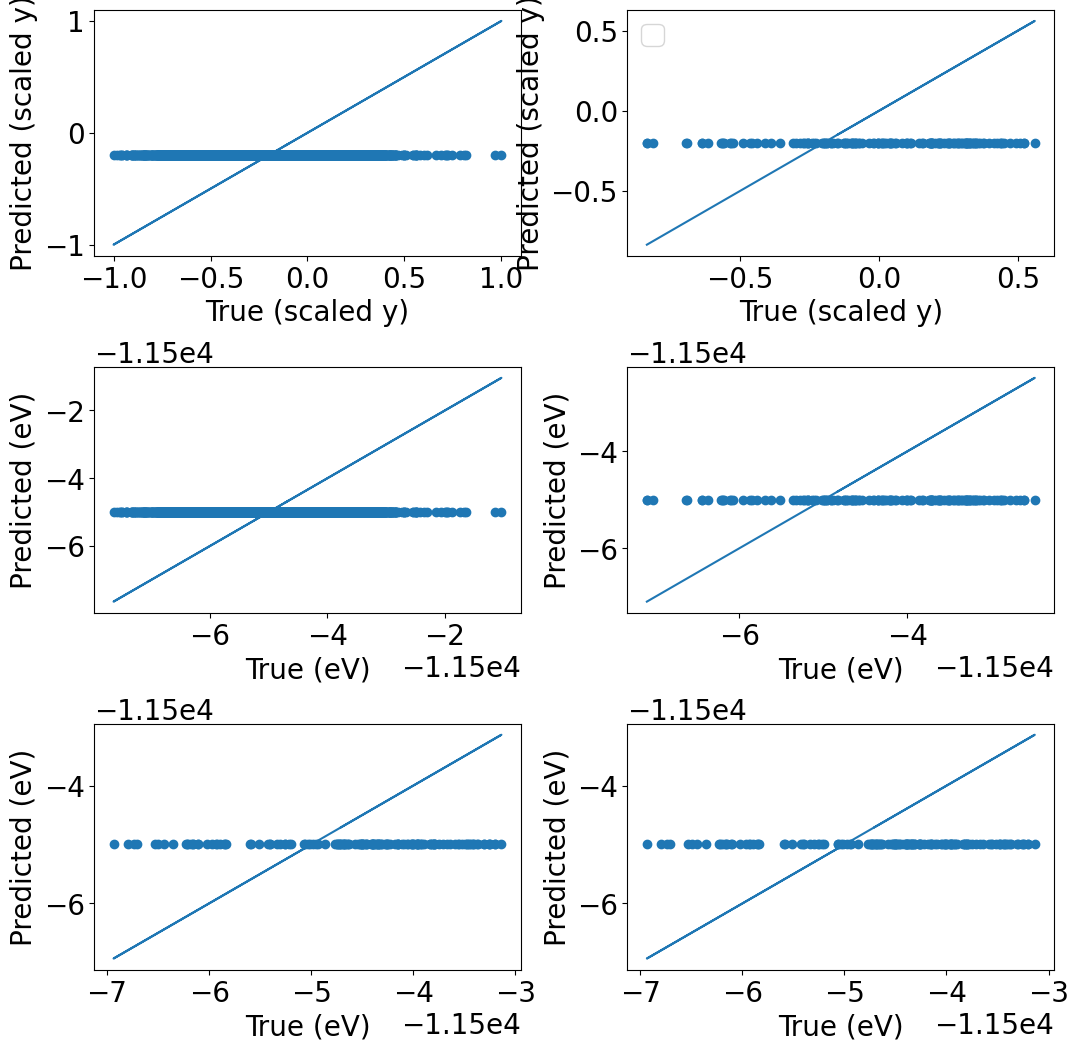

In [199]:
# Set the figure size
fig = plt.figure(figsize=(12, 12))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.45)

nrows=3
ncols=2

# Create a 3x3 grid
grid = GridSpec(nrows, ncols)

ax = plt.subplot(grid[0,0])

ax.scatter(gcn_train_y_target, gcn_train_target) #, label=f'R2:{np.round(gcn_train_loss,2)}')
ax.plot(gcn_train_y_target, gcn_train_y_target)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
#ax.legend()

ax = plt.subplot(grid[0,1])

ax.scatter(gcn_val_y_target, gcn_val_target) #, label=f'R2:{np.round(test_r2,2)}')
ax.plot(gcn_val_y_target, gcn_val_y_target)

ax.set_xlabel('True (scaled y)')
ax.set_ylabel('Predicted (scaled y)')
ax.legend()



ax = plt.subplot(grid[1,0])

ax.scatter(y_scaler.inverse_transform(gcn_train_y_target.reshape(-1,1)), 
           y_scaler.inverse_transform(gcn_train_target.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(gcn_train_y_target.reshape(-1,1)), 
        y_scaler.inverse_transform(gcn_train_y_target.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')

ax = plt.subplot(grid[1,1])

ax.scatter(y_scaler.inverse_transform(gcn_val_y_target.reshape(-1,1)), 
           y_scaler.inverse_transform(gcn_val_target.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(gcn_val_y_target.reshape(-1,1)), 
        y_scaler.inverse_transform(gcn_val_y_target.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')


ax = plt.subplot(grid[2,0])

ax.scatter(y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)), 
           y_scaler.inverse_transform(gcn_test_target.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)), 
        y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')

ax = plt.subplot(grid[2,1])

ax.scatter(y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)), 
           y_scaler.inverse_transform(gcn_test_target.reshape(-1,1)))
ax.plot(y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)), 
        y_scaler.inverse_transform(gcn_test_y_target.reshape(-1,1)))

ax.set_xlabel('True (eV)')
ax.set_ylabel('Predicted (eV)')

